# 다중회귀_예측 

목표변수 FAT를 예측하기 위한 파생변수(BMI 등)를  생성하여 회귀분석을 실시하여 결과를 해석하고, 
predict method를 이용하여 예측값을 구하라.

1. train 데이터: 모델 훈련 
2. test 데이터: 1에서 개발한 모델의 성능 평가


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 회귀분석
from statsmodels.formula.api import ols

# qqplot, 회귀분석의 상수항 추가
from statsmodels.api import qqplot, add_constant

# 선형 모델 formula(y ~ X1 + X2 + ...)
import statsmodels.formula.api as smf

# 다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 데이터셋 학습용 평가용 분리
from sklearn.model_selection import train_test_split

# 선형회귀모형
from sklearn.linear_model import LinearRegression

# 변수 선택법(후진제거법)
from sklearn.feature_selection import RFE

# Scale 변환->표준화 회귀계수 산출
from sklearn.preprocessing import StandardScaler

# 평가함수
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score

# jupyter notebook 사용 시 그래프 자동 출력 옵션
%matplotlib inline

import matplotlib
# 한글 폰트 적용
matplotlib.rc('font', family = 'Nanumgothic')

# 음수 표시
matplotlib.rc('axes', unicode_minus=False)


In [2]:
df_raw = pd.read_csv('./datasets/체질검사.csv', engine = 'python')
df_raw.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


In [3]:
df_raw['WEIGHT'] = df_raw['WEIGHT'] * 0.45
df_raw['HEIGHT'] = df_raw['HEIGHT'] * 2.54
df_raw['BMI'] = df_raw['WEIGHT'] / ((df_raw['HEIGHT']*0.01) **2)
df_raw.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,BMI
0,35.2,46,163.4175,183.515,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,48.523870
1,11.8,27,75.6000,180.975,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,23.082595
2,22.2,69,79.9875,173.990,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,26.422478
3,10.6,57,66.4875,167.005,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,23.838617
4,47.5,51,98.5500,162.560,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,37.293165


FAT을 예측하기 위해 BMI라는 파생변수를 생성, WEIGHT를 kg단위로, HEIGHT를 cm단위로 변경

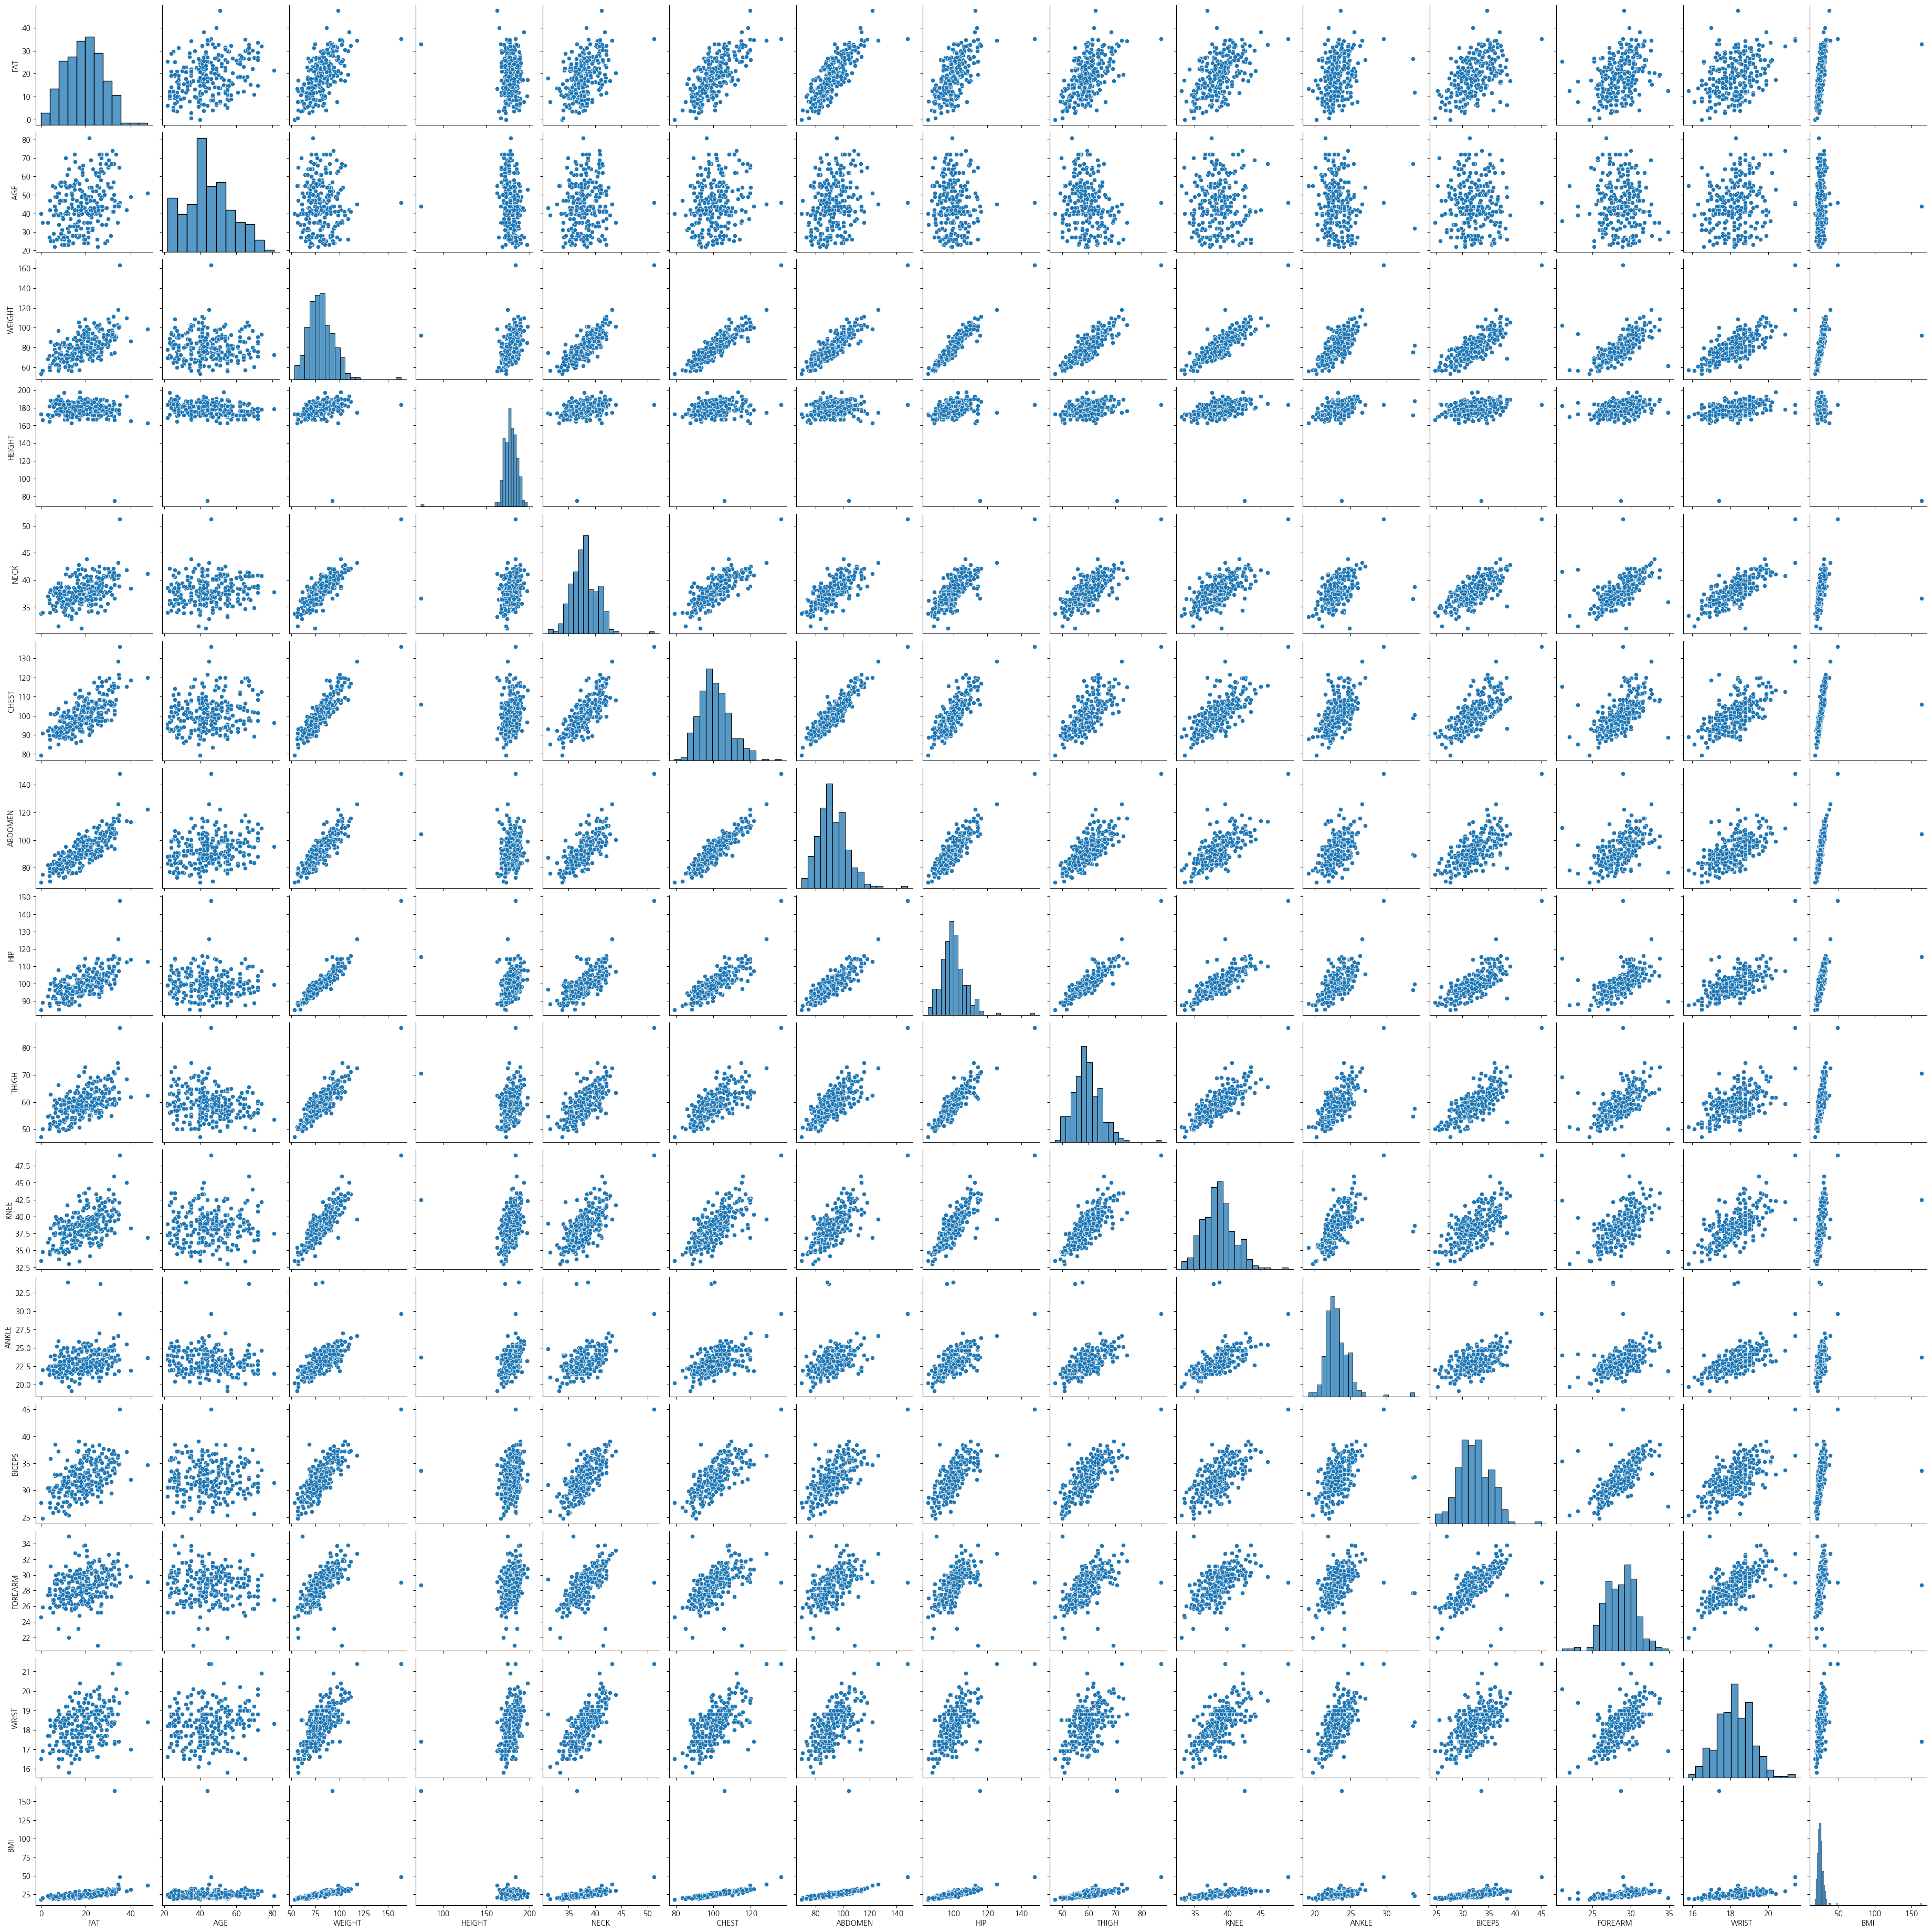

In [4]:
sns.pairplot(df_raw)

전체 변수에 대한 관계를 scattor plot으로 표현했는데, 선형관계를 보이는 변수들이 다수 확인된다. 이는 변수들 간의 다중공선성도 어느 정도 있을 것으로 예상됨. 더 자세한 분석을 위해 상관관계를 수치로 표현

In [5]:
df_raw.corr().round(3)

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,BMI
FAT,1.000,0.291,0.612,-0.089,0.491,0.703,0.813,0.625,0.560,0.509,0.266,0.493,0.361,0.347,0.371
AGE,0.291,1.000,-0.013,-0.172,0.114,0.176,0.230,-0.050,-0.200,0.018,-0.105,-0.041,-0.085,0.214,0.040
WEIGHT,0.612,-0.013,1.000,0.308,0.831,0.894,0.888,0.941,0.869,0.853,0.614,0.800,0.630,0.730,0.391
HEIGHT,-0.089,-0.172,0.308,1.000,0.254,0.135,0.088,0.170,0.148,0.286,0.265,0.208,0.229,0.322,-0.638
NECK,0.491,0.114,0.831,0.254,1.000,0.785,0.754,0.735,0.696,0.672,0.478,0.731,0.624,0.745,0.266
CHEST,0.703,0.176,0.894,0.135,0.785,1.000,0.916,0.829,0.730,0.719,0.483,0.728,0.580,0.660,0.383
ABDOMEN,0.813,0.230,0.888,0.088,0.754,0.916,1.000,0.874,0.767,0.737,0.453,0.685,0.503,0.620,0.415
HIP,0.625,-0.050,0.941,0.170,0.735,0.829,0.874,1.000,0.896,0.823,0.558,0.739,0.545,0.630,0.462
THIGH,0.560,-0.200,0.869,0.148,0.696,0.730,0.767,0.896,1.000,0.799,0.540,0.761,0.567,0.559,0.433
KNEE,0.509,0.018,0.853,0.286,0.672,0.719,0.737,0.823,0.799,1.000,0.612,0.679,0.556,0.665,0.364


WEIGHT, CHEST, ABDOMEN, HIP, THIGH 등의 설명변수들이 FAT이라는 목표변수와 상관관계가 있는 것으로 확인됨.

다만 ABDOMEN과 CHEST 간의 상관관계가 0.916으로 매우 높게 나오며, 그 이외에도 설명변수들 간의 선형관계도 확인되므로 다중공선성에 대한 처리가 필요하다고 판단.

<Axes: >

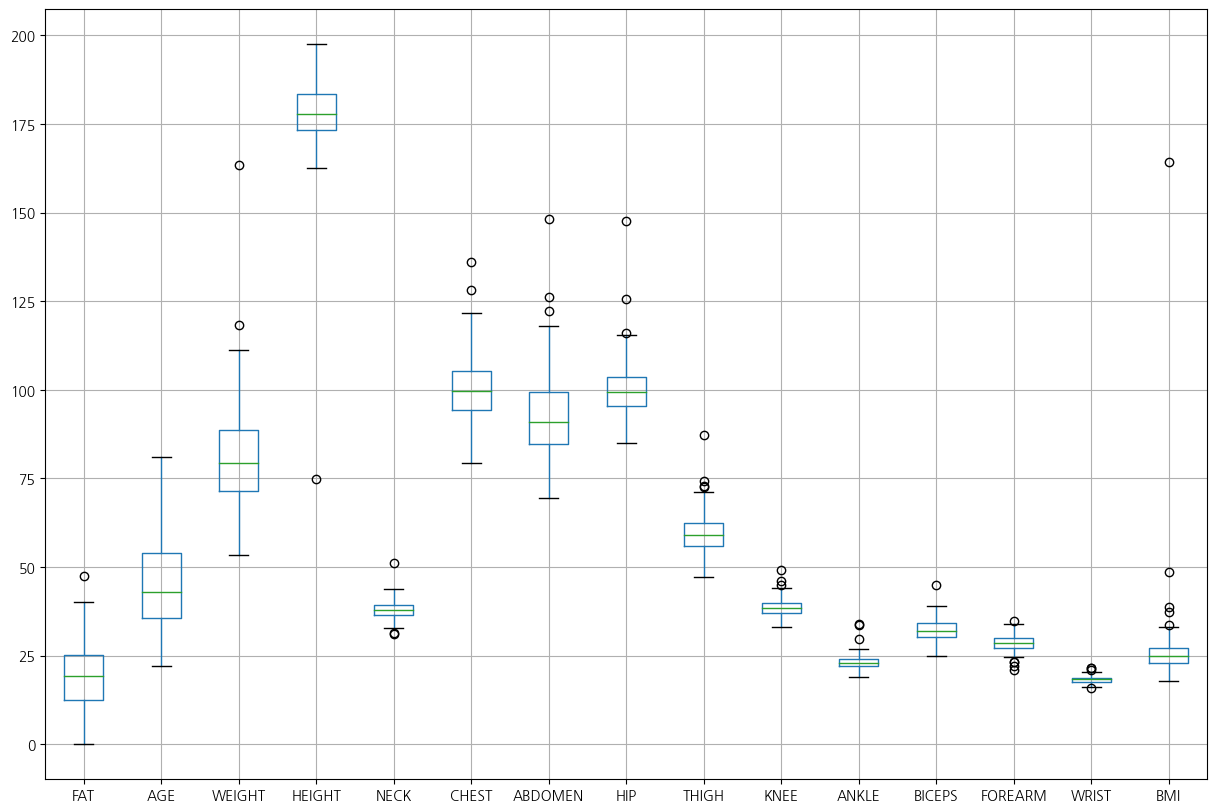

In [6]:
df_raw.boxplot(figsize = (15,10))

boxplot에서 보면 WEIGHT, HEIGHT, 그리고 파생된 BMI 등에 이상치가 존재하는 것으로 보이나 해당 데이터가 이상치가 확실한 지 확인할 수 
없어 일단은 데이터 사전 처리 없이 회귀분석 진행.

In [7]:
# train/test data 분리.
df_train, df_test = train_test_split(df_raw, test_size = 0.4, random_state = 1234)

print("train data size : {}".format(df_train.shape))
print("test data size : {}".format(df_test.shape))

train data size : (151, 15)
test data size : (101, 15)


In [8]:
#훈련용 데이터, 테스트 데이터의 목표변수, 설명변수를 나누어준다.
train_y = df_train['FAT']
train_x = df_train.drop('FAT',axis = 1)

test_y = df_test['FAT']
test_x = df_test.drop('FAT',axis = 1)

In [9]:
#모든 변수를 넣고 다중선형회귀를 진행한다.
model = smf.ols(formula = 'FAT~AGE+WEIGHT+HEIGHT+NECK+CHEST+ABDOMEN+HIP+THIGH+KNEE+ANKLE+BICEPS+FOREARM+WRIST+BMI',
                    data = df_train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     31.77
Date:                Tue, 23 Apr 2024   Prob (F-statistic):           5.19e-36
Time:                        23:16:14   Log-Likelihood:                -424.76
No. Observations:                 151   AIC:                             879.5
Df Residuals:                     136   BIC:                             924.8
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -51.7190     31.607     -1.636      0.1

전체 변수에 대한 회귀모델 생성.

우선 해당 모델에 대한 유의성 검정인 F검정의 p-value 값이 거의 0에 가까운 것으로 보아 해당 모델은 회귀모델로서 유의.

수정결정계수( Adj. R-squared )는 0.742로 이 모델을 통하여 설명변수를 74% 정도 설명할 수 있으므로 설명력이 꽤 높음.

Prob(Omnibus)값이 0.110로 유의수준을 0.05라고 보았을 때 잔차의 정규성 역시 만족, Durbin-Watson 값이 1.896이므로 잔차의 독립성도 만족.

앞에서 살펴 보았듯이 설명변수들 간의 다중공선성이 확인되므로 이를 확인한 후 제거하는 과정을 진행.

In [10]:
df_train_x = df_train.drop('FAT', axis = 1)
df_train_x_const = add_constant(df_train_x)

df_vif = pd.DataFrame()

df_vif['variable'] = df_train_x_const.columns # column 값들을 넣음
df_vif['VIF'] = [variance_inflation_factor(df_train_x_const.values, i) \
                for i in range(df_train_x_const.shape[1])]
df_vif.sort_values('VIF', inplace = True)
df_vif.round(3)

,variable,VIF
12,FOREARM,1.911
10,ANKLE,2.218
1,AGE,2.369
11,BICEPS,3.382
13,WRIST,3.451
4,NECK,4.591
9,KNEE,5.318
8,THIGH,9.258
14,BMI,10.300
5,CHEST,11.514


VIF값이 10이상이면 보통 다중공선성이 있다고 판단, WEIGHT의 경우 56.452로 매우 높게 나왔기 때문에 제거 필요

In [11]:
df_train_x = df_train.drop(['FAT', 'WEIGHT'], axis = 1)
df_train_x_const = add_constant(df_train_x)

df_vif = pd.DataFrame()

df_vif['variable'] = df_train_x_const.columns # column 값들을 넣음
df_vif['VIF'] = [variance_inflation_factor(df_train_x_const.values, i) \
                for i in range(df_train_x_const.shape[1])]
df_vif.sort_values('VIF', inplace = True)
df_vif.round(3)

,variable,VIF
11,FOREARM,1.911
9,ANKLE,2.028
1,AGE,2.336
10,BICEPS,3.198
12,WRIST,3.429
3,NECK,3.900
8,KNEE,5.203
2,HEIGHT,6.758
13,BMI,6.791
7,THIGH,9.094


ABDOMEN과 HIP 모두 여전히 VIF값이 10을 넘지만, 앞서서 FAT과의 상관관계를 확인했을 때, 이 두 값 모두 목표변수와의 상관성이 높았기 때문에 중요변수일 확률이 높아서 제거하지 않는다.

In [12]:
model = smf.ols(formula = 'FAT~AGE+HEIGHT+NECK+CHEST+ABDOMEN+HIP+THIGH+KNEE+ANKLE+BICEPS+FOREARM+WRIST+BMI',
                    data = df_train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     33.35
Date:                Tue, 23 Apr 2024   Prob (F-statistic):           4.56e-36
Time:                        23:16:20   Log-Likelihood:                -426.64
No. Observations:                 151   AIC:                             881.3
Df Residuals:                     137   BIC:                             923.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.2911     10.937      0.301      0.7

설명변수 중 WEIGHT 값을 제거한 후에도 수정 결정계수인 Adj. R-squared 값이 0.737으로 앞선 전체 설명변수에 대한 값인 0.742과 거의 차이가 없음.
즉, WEIGHT는 목표변수에 큰 영향을 주지 않는 것으로 판단.

p-value가 0.05이하인 통계적으로 유의한 설명변수들만 선택한 회귀모델 실행.

In [13]:
# p-value가 0.05이하인 설명변수들 : NECK ABDOMEN  HIP FOREARM
    
model = smf.ols(formula = 'FAT~NECK + ABDOMEN + HIP + FOREARM', data = df_train)
result = model.fit()
result.summary()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     100.6
Date:                Tue, 23 Apr 2024   Prob (F-statistic):           5.94e-41
Time:                        23:16:22   Log-Likelihood:                -434.42
No. Observations:                 151   AIC:                             878.8
Df Residuals:                     146   BIC:                             893.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.7792      6.876     -1.422      0.1

설명변수 NECK, ABDOMEN, HIP, FOREARM에 대한 회귀모델 생성.

최종 모델의 회귀식 : y = -9.7792 -0.9383*NECK + 0.9971*ABDOMEN -0.4037*HIP + 0.4328*FOREARM

해당 모델에 대한 유의성 검정인 F검정의 p-value 값이 거의 0에 가까운 것으로 보아 해당 모델은 유의.

수정결정계수( Adj. R-squared )는 0.727로 4개의 설명변수 만으로도 전체변동의 73% 정도 설명할 수 있으므로 설명력이 꽤 높음.
(모든 설명변수를 포함한 경우에 비해 크게 차이가 나지 않음)

잔차의 정규성, 등분산성, 독립성 진단 진행

In [14]:
from scipy.stats import shapiro

ShapiroResult(statistic=0.9831816554069519, pvalue=0.06233511492609978)

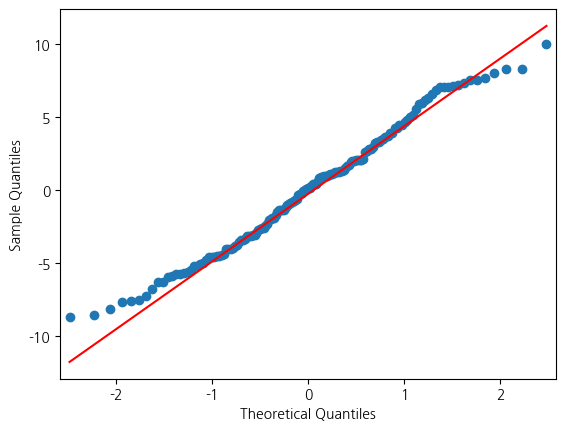

In [15]:
# 잔차의 정규확률도 (정규성)
qqplot(result.resid,line = 'q')
# 잔차의 정규성 검정
shapiro(result.resid)

정규성 검정결과 p값 0.062으로 0.05보다 크므로 잔차의 정규성 만족

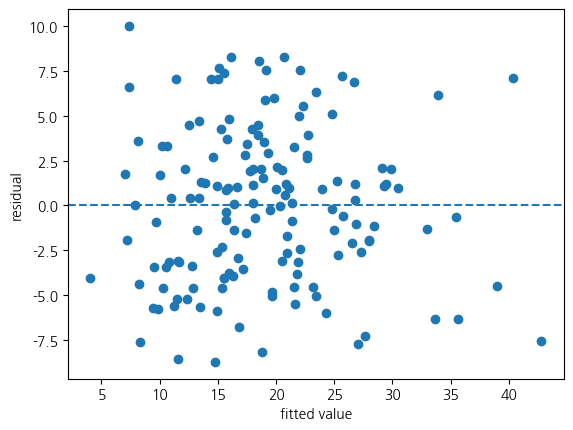

In [16]:
#잔차 vs 예측값 (등분산성)
plt.scatter(result.fittedvalues, result.resid)
plt.xlabel('fitted value')
plt.ylabel('residual')
plt.axhline(y = 0, linestyle = '--')

산점도에 별 다른 패턴이 보이지는 않음. 등분산성을 만족하는 것 같음.

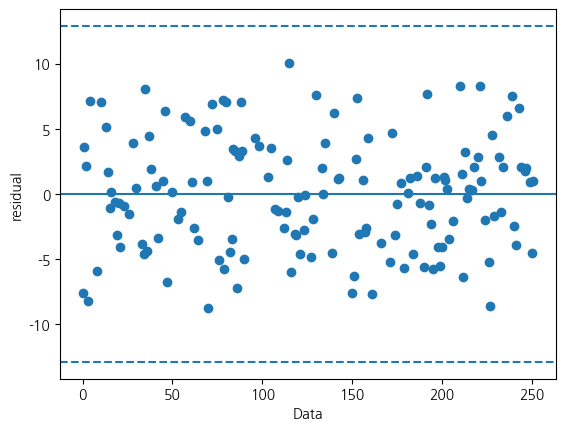

In [17]:
#잔차 vs 관측순서 (독립성)
plt.scatter(df_train.index, result.resid, marker="o")
plt.xlabel("Data")
plt.ylabel("residual")
plt.axhline(y = 0, linestyle = "-")
plt.axhline(y = 3*np.std(result.resid), linestyle = "--")
plt.axhline(y = -3*np.std(result.resid), linestyle = "--")

관측순서에 따라 잔체에 특별한 패턴이 없이 골고루 퍼져 있으므로 독립성 만족(자기상관이 없음.)

In [18]:
train_pred = result.predict(df_train)
test_pred = result.predict(df_test)
print("train data의 결정계수:", r2_score(df_train['FAT'], train_pred))
print("test data의 결정계수 :", r2_score(df_test['FAT'], test_pred))


train data의 결정계수: 0.7338297780133076
test data의 결정계수 : 0.6882307014897417


설명변수이 중요도 : 회귀계수 기준

<Axes: >

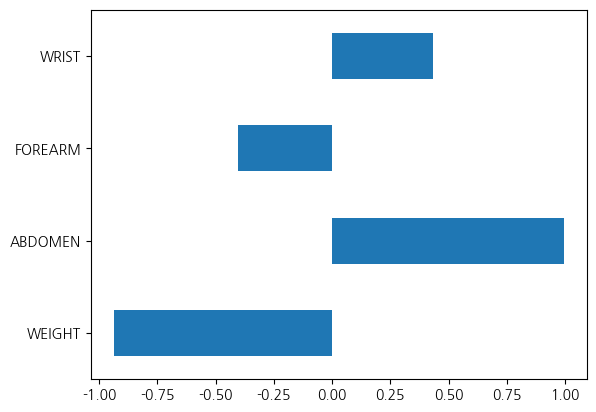

In [19]:
# 설명변수 중요도
selected_cols = ['WEIGHT', 'ABDOMEN', 'FOREARM', 'WRIST']
df_reg_coef = pd.DataFrame({"Coef": result.params.values[1:]}, index = selected_cols)
df_reg_coef.plot.barh(y = "Coef", legend = False)


예측값 구하기

In [20]:
# test 데이터셋에서의 예측값 구하기
test_pred = result.predict(test_x)
test_pred

208    13.020303
94     18.059894
31     36.468647
248    19.006562
216    22.287221
         ...    
101    30.558196
100    23.960425
237    20.199106
49      6.102477
126    18.774266
Length: 101, dtype: float64